Steps:

- Load data and visualize a sample of them
- Check for distribution across classes

In [124]:
# Run following commands if running on local
# !pip install kaggle

# Download kaggle.json from kaggle website under profile->new API section
# !kaggle competitions download -c plant-seedlings-classification
# !unzip -q plant-seedlings-classification.zip

In [125]:
from torch.utils.data import Dataset
import os, glob
from PIL import Image

class ImgDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.imgs = glob.glob(os.path.join(root, '*.png'))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx])
        if self.transform:
            img = self.transform(img)
        return img, 1

In [126]:
os.chdir('/kaggle/input/plant-seedlings-classification/')

In [127]:
# Folder structure
# Training data
# contains images in 12 folders, each folder contains images of a single class
# Test data
# contains all images in a single folder

# Load the data
from torchvision import datasets, transforms

transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder('./train', transform=transforms)
testDataset = ImgDataset('./test', transform=transforms)

### Class Distribution

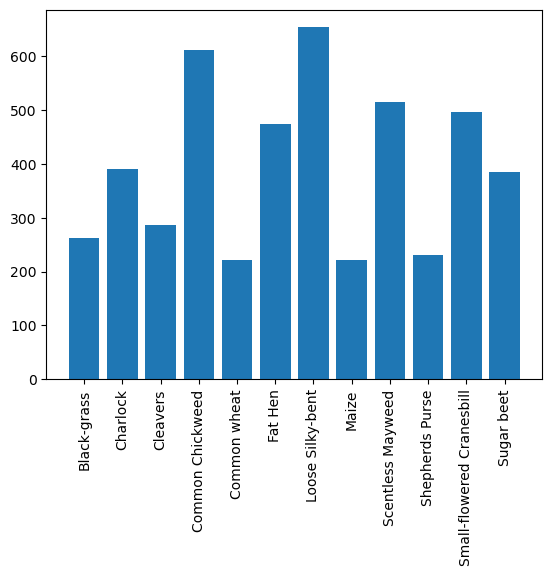

In [128]:
# Plot class distribution
from collections import Counter
import matplotlib.pyplot as plt

distribution = dict(Counter(dataset.targets))

# Plot class distribution histogram
plt.bar(list(map(lambda x: dataset.classes[x], distribution.keys())), distribution.values())
plt.xticks(rotation=90)
plt.show()

### Sampling imbalance classes

In [201]:
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler

def sampler(indices):
    labels = [dataset.targets[x] for x in indices]
    print(f'label length: {len(labels)}')
    distribution = dict(Counter(labels))
    class_weights = {k: 1/v for k, v in distribution.items()}

    samples_weight = np.array([class_weights[t] for t in labels])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [210]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset

# Split validation data from training data
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices) # shuffle the dataset before splitting into train and val
print(f'dataset_size: {dataset_size}')

split = int(np.floor(0.8 * dataset_size))
train_indices, val_indices = indices[:split], indices[split:]

BATCH_SIZE = 64

train = DataLoader(Subset(dataset, train_indices), sampler=sampler(train_indices), batch_size=BATCH_SIZE)
val = DataLoader(Subset(dataset, val_indices), sampler=sampler(val_indices), batch_size=BATCH_SIZE)
test = DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=True)

dataset_size: 4750
label length: 3800
label length: 950


### Visualize distribution after sampling

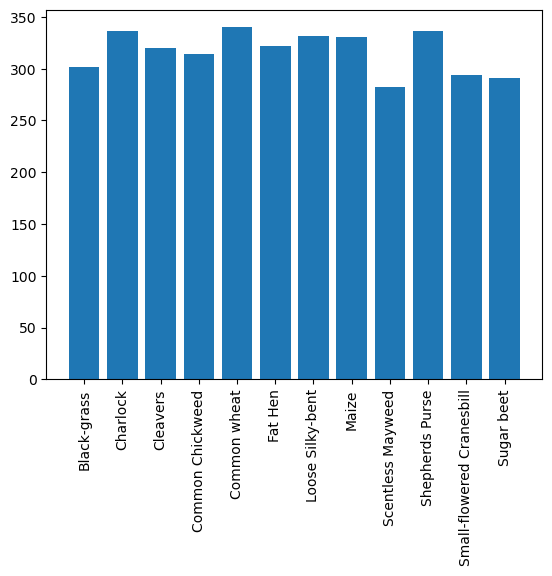

In [203]:
# Plot class distribution histogram for training data
class_counts = [0]*len(dataset.classes)

for i, (_, label) in enumerate(train):
    for l in label:
        class_counts[l] += 1

# Plot class distribution histogram
plt.bar(dataset.classes, class_counts)
plt.xticks(rotation=90)
plt.show()

# Not sure if something is wrong with the visualization
# Another explanation could be batches are somewhat balanced 
# but the discrepancy adds up overall

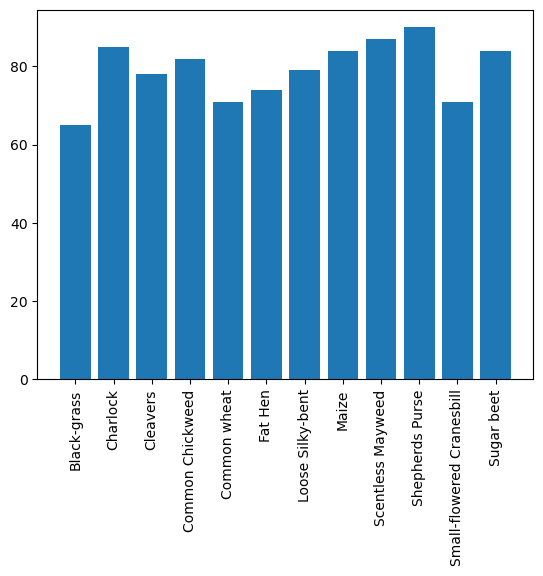

In [204]:
# Plot class distribution histogram for validation data
class_counts = [0]*len(dataset.classes)

for i, (_, label) in enumerate(val):
    for l in label:
        class_counts[l] += 1

# Plot class distribution histogram
plt.bar(dataset.classes, class_counts)
plt.xticks(rotation=90)
plt.show()

### Visualize images

In [208]:
def visualizeBatch(batch, classes=None):
    # sample 8 indexes from BATCH_SIZE
    indexes = np.random.choice(BATCH_SIZE, 8, replace=False)
    for i, j in enumerate(indexes):
        image, idx = batch[0][j], batch[1][j]
        
        ax = plt.subplot(2, 4, i + 1)
        image = image.cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (255.0 * image).astype('uint8')
        
        plt.imshow(image)
        if classes is not None:
            plt.title(classes[idx])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

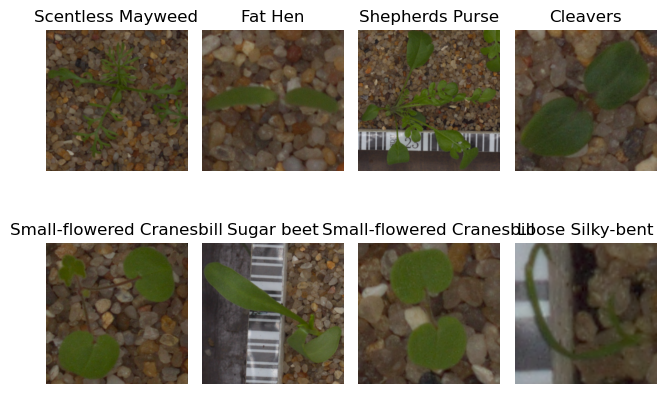

In [211]:
trainBatch = next(iter(train))
visualizeBatch(trainBatch, dataset.classes)

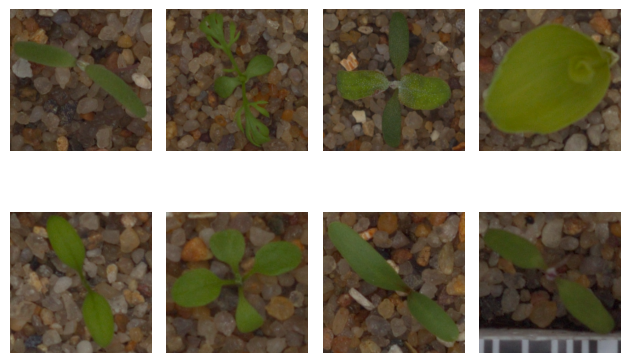

In [133]:
testBatch = next(iter(test))
visualizeBatch(testBatch)